In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

Using TensorFlow backend.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-09-24 06:58:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.7.202.148, 3.224.23.57, 52.23.2.88, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.7.202.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  19.0MB/s    in 0.7s    

2019-09-24 06:58:32 (19.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [6]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://b20c9c20.ngrok.io


In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=128,
                         write_images=True)

In [8]:
input_img = Input(shape=(28, 28, 1))    # adapt this if using 'channels_first' image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



# at this point the representation is (4, 4, 8), i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# autodecoder = Model(input_img, encoded)
# autodecoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# To train it, use the original MNIST digits with shape (samples, 3, 28, 28),
# and just normalize pixel values between 0 and 1

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))    # adapt this if using 'channels_first' image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))       # adapt this if using 'channels_first' image data format

# open a terminal and start TensorBoard to read logs in the autoencoder subdirectory
# tensorboard --logdir=autoencoder

autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test),
                callbacks=[tbCallBack], verbose=1)

autoencoder.save('/content/drive/encoder_decoder.h5',include_optimizer=True)

# take a look at the reconstructed digits
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

# take a look at the 128-dimensional encoded representation
# these representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

# save latent space features 128-d vector
pickle.dump(encoded_imgs, open('/content/drive/conv_autoe_features.pickle', 'wb'))

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.set_axis_off()

plt.show()
encoder.save('/content/drive/encoder.h5')
K.clear_session()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11493376/11490434 [==============================] - 1s 0us/step

Train on 60000 samples, validate on 10000 samples




Epoch 1/50
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2902 - val_loss: 0.2460
Epoch 2/50
60000/60000 [==============================] - 83s 1ms/step - loss: 0.2155 - val_loss: 0.2017
Epoch 3/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1979 - val_loss: 0.1988
Epoch 4/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1892 - val_loss: 0.2103
Epoch 5/50
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1830 - val_loss: 0.1768
Epoch 6/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1777 - val_loss: 0.1724
Epoch 7/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1708 - val_loss: 0.1727
Epoch 8/50
60000/60000 [====================

OSError: ignored

In [0]:
autoencoder.save('encoder_decoder.h5')

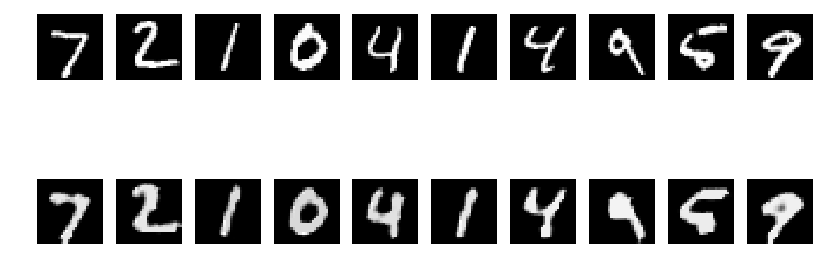

In [17]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

In [0]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

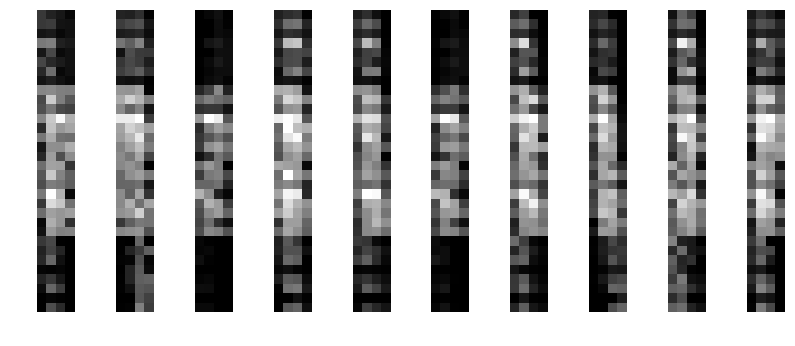

In [19]:
n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.set_axis_off()

plt.show()

In [0]:
encoder.save('encoder.h5')